In [12]:
import importlib.util
import os
import sys
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from data_loader import MyDataLoader, SPLIT
from my_config import MyConfig, load_config
import numpy as np
import pandas as pd

In [13]:
import json


def load_module_from_folder(folder_path: str, module_name: str):
    """
    Dynamically load a module from <folder_path>/<module_name>.py
    and return the imported module object.
    """
    module_path = os.path.join(folder_path, f"{module_name}.py")
    if not os.path.isfile(module_path):
        raise FileNotFoundError(f"No such file: {module_path}")

    spec = importlib.util.spec_from_file_location(module_name, module_path)
    module = importlib.util.module_from_spec(spec)
    # make it available in sys.modules in case it imports other local files
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

# Example usage:
run_folder = Path(rf'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250611-164753_LSTM_DNI_STATION_ECMWF_CELL_1_1_32')
SimpleLSTM = load_module_from_folder(run_folder, 'models').SimpleLSTM

my_config: MyConfig = load_config(run_folder / 'config.json')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open(run_folder / 'model_architecture.json', 'r') as f:
    model_state = json.load(f)

model = SimpleLSTM(input_size=model_state['input_size'],
                    hidden_size=model_state['hidden_size'],
                    output_size= model_state['output_size'],
                    num_layers=model_state['num_layers'],
                    dropout=model_state['dropout']).to(DEVICE)

d:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


# Load checkpoint

In [14]:
# Find all checkpoint files in the directory following the pattern checkpoint_{epoch}.pt
checkpoint_files = [f for f in os.listdir(run_folder) if f.startswith('checkpoint_') and f.endswith('.pt')]
if checkpoint_files:
    # Sort files by epoch number in descending order and choose the latest checkpoint.
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]), reverse=True)
    latest_checkpoint_file = checkpoint_files[0]
    print(f"Loading latest checkpoint: {latest_checkpoint_file}")

    model.load_state_dict(torch.load(run_folder / latest_checkpoint_file, map_location=DEVICE)['model_state_dict'])
else:
    raise FileNotFoundError(f"No checkpoint files found in {run_folder}")

Loading latest checkpoint: checkpoint_40.pt


# Load test data

In [15]:
from TimeSeriesDataset import TimeSeriesDatasetGPU
from _utils import load_scaler_and_transform_df

data_loader = MyDataLoader(my_config)
data_loader.load_data()
if model_state['input_size'] > 12:
    data_loader.load_ecmwf_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=True, drop_nan=True)


method = 'minmax'  # or 'standard', 'maxabs', 'robust', 'normalizer'
scalar_file = run_folder / f'{method}.pkl'
if not os.path.exists(scalar_file):
    raise FileNotFoundError(f"Scalar file {scalar_file} does not exist. Please check the path.")


# 3) SCALE val split using existing scaler, convert to NumPy
df_test = load_scaler_and_transform_df(scalar_file, data_loader.get_split(SPLIT.TEST))
X_test_df = df_test[data_loader.get_feature_names()]
y_test_df = df_test[data_loader.get_target_names()]
ts_test = df_test.index.to_numpy()

X_test_full = X_test_df.to_numpy().astype(np.float32)
y_test_full = y_test_df.to_numpy().astype(np.float32)

test_dataset = TimeSeriesDatasetGPU(
    X_full=X_test_full,
    y_full=y_test_full,
    ts_full=ts_test,
    input_seq_len=my_config.INPUT_SEQ_LEN,
    gap_threshold_minutes=my_config.GAP_THRESHOLD,
    device=DEVICE
)
test_loader = DataLoader(
    test_dataset,
    batch_size=my_config.BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    pin_memory=False,
    num_workers=0
)
del y_test_full, X_test_full, ts_test, df_test

# Make predictions

In [16]:
model.eval()
all_preds = []
all_truths = []
all_idx = []
with torch.no_grad():
    for batch_X, batch_y, idx in test_loader:
        preds = model(batch_X)
        all_preds.append(preds.cpu().numpy())
        all_truths.append(batch_y.cpu().numpy())
        all_idx.append(idx.cpu().numpy())


all_preds = np.concatenate(all_preds).squeeze()
all_truths = np.concatenate(all_truths).squeeze()
all_idx = np.concatenate(all_idx).squeeze()

tmp = np.full((len(all_idx), test_dataset.seq_len), np.datetime64('NaT'), dtype='datetime64[ns]')
for idx in all_idx:
    # idx is an index into the list of valid starts
    start = int(test_dataset.valid_start_idxs[idx])
    end = start + test_dataset.seq_len  # exclusive

    # Extract feature‐slice and the “last‐timestep” target
    tmp[idx] = test_dataset.ts_full[start:end]          # shape = (seq_len, num_features)

all_idx = tmp
display(all_preds.shape, all_truths.shape, all_idx.shape)

(222720, 60)

(222720, 60)

(222720, 60)

In [17]:
import numpy as np
import pickle
from pathlib import Path

def inverse_transform_feature(values: np.ndarray,
                              column_name: str,
                              scaler_path: Path):
    """
    Inverse‐transform a 1D array `values` which contains only the scaled
    feature `column_name`.  `scaler_path` should point to the pickled
    MinMaxScaler that was fitted on your training data.
    """
    # 1) Load the fitted scaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # 2) Find index k of the target column in scaler.feature_names_in_
    k = scaler.feature_names_in_.tolist().index(column_name)

    # 3) Grab the transformation parameters for that column
    scale_k = scaler.scale_[k]   # equals (feature_range[1]-feature_range[0])/(data_max - data_min)
    min_k   = scaler.min_[k]     # equals feature_range[0] - data_min*scale_k

    # 4) Apply inverse transform on the 1D array:
    #    X_orig = (X_scaled - min_k) / scale_k
    y_orig = (values - min_k) / scale_k

    # 5) Return with the same shape you passed in
    return y_orig.reshape(values.shape)

import pickle
from pathlib import Path
import numpy as np

def inverse_transform_standard_feature(values: np.ndarray,
                                       column_name: str,
                                       scaler_path: Path) -> np.ndarray:
    """
    Inverse‐transform a 1D array `values` which contains only the scaled
    feature `column_name`. `scaler_path` should point to the pickled
    StandardScaler that was fitted on your training data.
    """
    # 1) Load the fitted StandardScaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # 2) Find index k of the target column in scaler.feature_names_in_
    k = scaler.feature_names_in_.tolist().index(column_name)

    # 3) Grab the transformation parameters for that column
    mean_k  = scaler.mean_[k]    # the training-set mean of the feature
    scale_k = scaler.scale_[k]   # the training-set std deviation of the feature

    # 4) Apply inverse transform on the 1D array:
    #    X_orig = X_scaled * scale_k + mean_k
    y_orig = values * scale_k + mean_k

    # 5) Return with the same shape you passed in
    return y_orig.reshape(values.shape)


scaler_file = run_folder / f"{method}.pkl"
scale = inverse_transform_feature
if method == 'standard':
    scale = inverse_transform_standard_feature
all_preds = scale(
    all_preds.ravel(), 
    data_loader.get_target_names()[0],
    scaler_file).reshape(all_preds.shape)
all_truths = scale(
    all_truths.ravel(), 
    data_loader.get_target_names()[0],
    scaler_file).reshape(all_truths.shape)

In [18]:
all_truths = pd.DataFrame(all_truths, index=all_idx[:, 0])
all_preds = pd.DataFrame(all_preds, index=all_idx[:, 0])
all_idx = pd.DataFrame(all_idx, index=all_idx[:, 0])
all_truths.sort_index(inplace=True)
all_preds.sort_index(inplace=True)
display(all_truths.head(), all_preds.head(), all_idx.head())

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.009686,0.004017,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998
2024-01-01 07:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.004017,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605
2024-01-01 07:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.012477,...,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777
2024-01-01 07:46:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012477,0.005728,...,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777,0.042302
2024-01-01 07:47:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012477,0.005728,0.013645,...,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777,0.042302,0.031951


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,140.373254,88.117800,56.884087,37.553492,26.802487,20.440352,14.898907,10.692016,9.874983,7.237008,...,0.813662,2.626203,4.029326,4.668451,3.556456,3.846211,3.946228,2.636199,4.071800,3.888432
2024-01-01 07:44:00,139.768681,88.939831,57.726975,38.556937,27.826415,19.589856,13.691162,11.808994,8.485451,7.886547,...,2.626203,4.029326,4.668451,3.556456,3.846211,3.946228,2.636199,4.071800,3.888432,3.342654
2024-01-01 07:45:00,141.001549,90.063910,58.930811,40.214367,27.043397,18.422422,14.843945,10.437142,9.149462,7.724558,...,4.029326,4.668451,3.556456,3.846211,3.946228,2.636199,4.071800,3.888432,3.342654,3.444744
2024-01-01 07:46:00,141.366316,90.811407,60.304752,38.835473,25.767384,19.519528,13.427396,11.076223,8.971062,8.366414,...,4.668451,3.556456,3.846211,3.946228,2.636199,4.071800,3.888432,3.342654,3.444744,3.131820
2024-01-01 07:47:00,141.905201,92.066429,58.824588,37.392636,26.847378,18.078557,14.056705,10.891422,9.610590,9.850978,...,3.556456,3.846211,3.946228,2.636199,4.071800,3.888432,3.342654,3.444744,3.131820,2.851732


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,2024-01-01 07:43:00,2024-01-01 07:44:00,2024-01-01 07:45:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,...,2024-01-01 08:33:00,2024-01-01 08:34:00,2024-01-01 08:35:00,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00
2024-01-01 07:44:00,2024-01-01 07:44:00,2024-01-01 07:45:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,...,2024-01-01 08:34:00,2024-01-01 08:35:00,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00
2024-01-01 07:45:00,2024-01-01 07:45:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,2024-01-01 07:54:00,...,2024-01-01 08:35:00,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00,2024-01-01 08:44:00
2024-01-01 07:46:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,2024-01-01 07:54:00,2024-01-01 07:55:00,...,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00,2024-01-01 08:44:00,2024-01-01 08:45:00
2024-01-01 07:47:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,2024-01-01 07:54:00,2024-01-01 07:55:00,2024-01-01 07:56:00,...,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00,2024-01-01 08:44:00,2024-01-01 08:45:00,2024-01-01 08:46:00


# Plot predictions

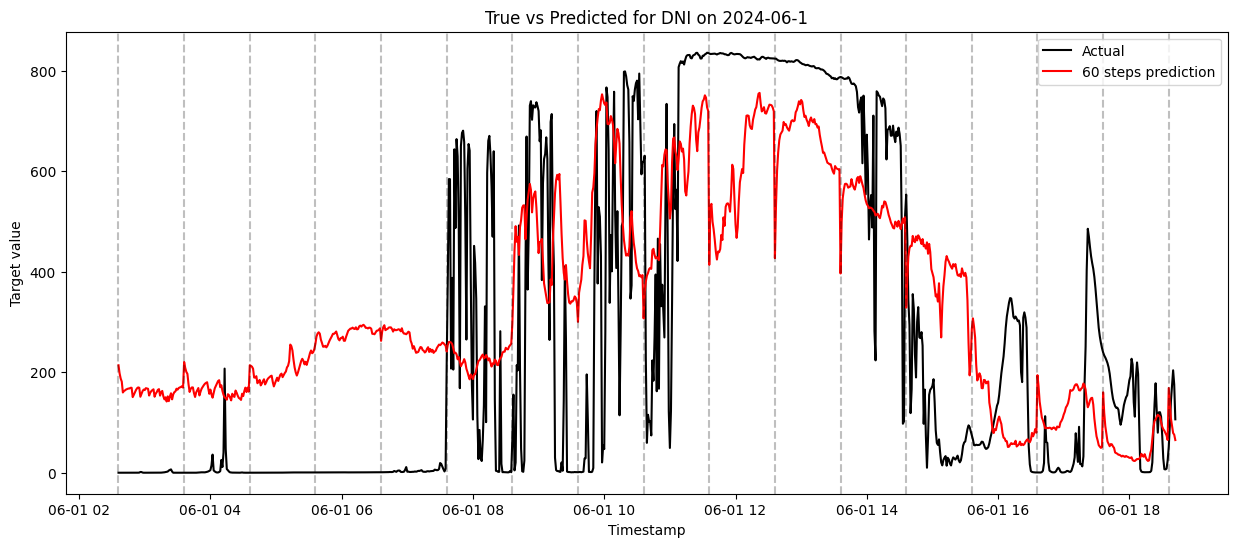

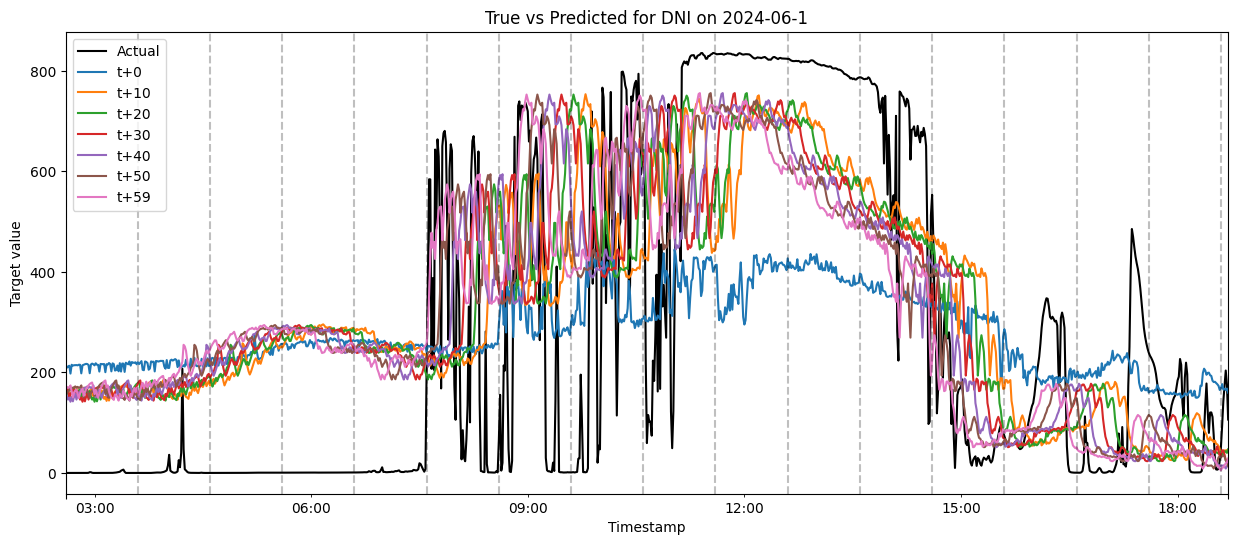

In [19]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))
# Select a specific day
day = '2024-06-1'
day_start = pd.to_datetime(day)
day_end = day_start + pd.Timedelta(days=1)
# Filter the timestamps for the selected day
day_mask = (all_idx.index >= day_start) & (all_idx.index < day_end)
day_ts = all_idx[day_mask][0].values

# Plot actual values
ax.plot(day_ts, all_truths[day_mask][0].values, label='Actual', color='black')
ax.plot(day_ts, all_preds[day_mask][::60].values.flatten()[:len(day_ts)], label='60 steps prediction', color='red')
# add vertical lines at every 60th timestep
for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)

ax.set_title(f"True vs Predicted for {my_config.get_df_target_names()[0]} on {day}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
all_truths[day_mask][0].plot(ax=ax, label='Actual', color='black', title=f"True vs Predicted for {my_config.get_df_target_names()[0]} on {day}", xlabel="Timestamp", ylabel="Target value", legend=True)
prediction_steps = list(range(0, 60, 10))
prediction_steps.append(59)
for i in prediction_steps:
    all_preds[day_mask][::1][i].plot(ax=ax, label=f"t+{i}", legend=True)

for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)

plt.show()

In [20]:
from ForecastEvaluator import ForecastEvaluator


def calculate_errors(y_true, y_pred):
    return ForecastEvaluator().evaluate_all(y_true, y_pred)


error_metrics = {}
for i in range(60):
    error_metrics[f't+{i}'] = calculate_errors(all_truths[0], all_preds[i])

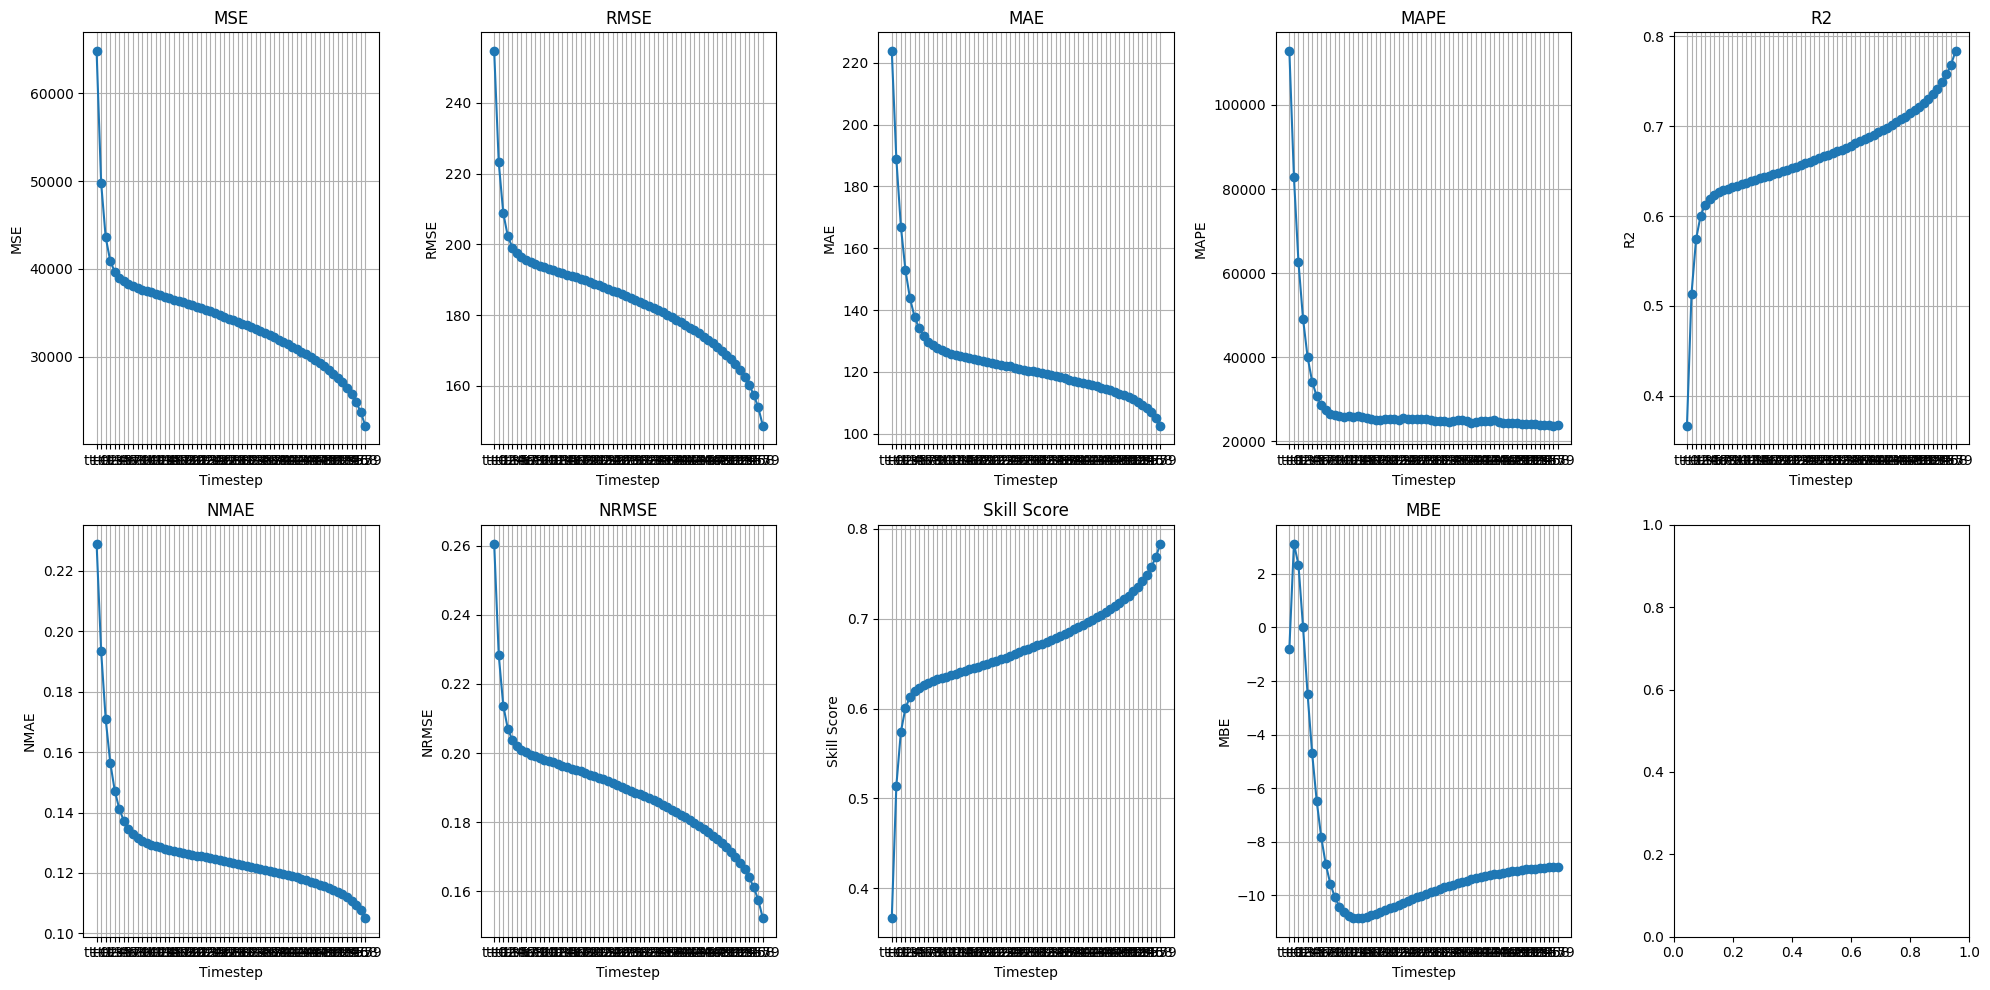

In [21]:
# Extract the timestep keys and error metrics
timesteps = list(error_metrics.keys())
metrics = list(error_metrics['t+56'].keys())

# Prepare figure and axes for subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()

# Plot each metric on a separate subplot
for i, metric in enumerate(metrics):
    values = [error_metrics[all_idx][metric] for all_idx in timesteps]
    axs[i].plot(timesteps, values, marker='o')
    axs[i].set_title(metric)
    axs[i].set_xlabel('Timestep')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [22]:
# name = run_folder.name[run_folder.name.find('_')+1:]
# all_truths.to_pickle(fr'LSTM_truths_{name}.pkl')
# all_preds.to_pickle(fr'LSTM_preds_{name}.pkl')
all_preds.to_pickle(run_folder / 'predictions.pkl')